# Student number: 202125489

# Assignment

## 771767 - AI-Based Offensive Text Detection System (Natural Lnaguage Processing)

# Dependencies

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
import time
import itertools
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics.pairwise import cosine_similarity
from keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import Dense,Embedding,SimpleRNN,LSTM,GRU,Dropout,Input, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.preprocessing.text import text_to_word_sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report

---

# Load data

In [10]:
#load dataset into dataframe
twitter_df1 = pd.read_csv('twitter_hate_speech_and_offensive_lang.csv')
twitter_df2 = pd.read_csv('Tweets.csv')

In [11]:
twitter_df1.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [12]:
twitter_df2.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [13]:
#create a new column for tweet label and map class accordingly
twitter_df1['label'] = twitter_df1['class'].map({0:'hate_speech',1:'offensive_language',2:'neither'})
twitter_df1.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,label
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language


In [14]:
#reduce dataframe to only the needed columns: tweets, label
twitter_df1 = twitter_df1[['tweet','label']]
twitter_df1.head()

,tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language


In [15]:
#rename column accordingly
twitter_df2 = twitter_df2[['selected_text','sentiment']].rename(columns={'selected_text': 'tweet', 'sentiment': 'label'})
twitter_df2.head()

,tweet,label
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


---

# Data Cleaning and Preprocessing

In [16]:
# text cleaning function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower() #make lower case
    text = re.sub('\[.*?\]', ' ', text) #remove text in square brackets
    text = re.sub('https?://\S+|www\.\S+', ' ', text) #remove links
    text = re.sub('rt|cc', ' ', text) #remove rt and cc
    text = re.sub('@\S+', ' ', text) #remove mentions
    text = re.sub('#\S+', ' ', text) #remove hastags
    text = re.sub('<.*?>+', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) #remove punctuations
    text = re.sub('\n', ' ', text) #remove newlines
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\s+', ' ', text) #remove extra white spaces
    return text

In [17]:
#clean text by applying clean_text function to each row
twitter_df1['tweet_clean'] = twitter_df1['tweet'].apply(clean_text)
twitter_df1.head()

,tweet,label,tweet_clean
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,as a woman you shouldn t complain about clean...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,boy dats cold tyga dwn bad for cuffin dat hoe...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,dawg you ever fuck a bitch and she sta to cry...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,she look like a tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,s the shit you hear about me might be true or...


In [25]:
#apply text cleaning function to twitter_df2
twitter_df2['tweet_clean'] = twitter_df2['tweet'].apply(clean_text)
twitter_df2.head()

,tweet,label,tweet_clean
0,"I`d have responded, if I were going",neutral,i d have responded if i were going
1,Sooo SAD,negative,sooo sad
2,bullying me,negative,bullying me
3,leave me alone,negative,leave me alone
4,"Sons of ****,",negative,sons of


In [26]:
#function to remove stop words from text
stop_words = stopwords.words('english') #initialize stopwords object

def remove_stopwords(text):
    ''' Remove stop words from text'''
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [27]:
#clean text further by applying the remove_stopwords function  
twitter_df1['tweet_clean'] = twitter_df1['tweet_clean'].apply(remove_stopwords)
twitter_df1.head()

,tweet,label,tweet_clean
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,woman complain cleaning house amp man always ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,boy dats cold tyga dwn bad cuffin dat hoe place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,dawg ever fuck bitch sta cry confused shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,shit hear might true might faker bitch told ya


In [28]:
#remove stop words from twitter_df2
twitter_df2['tweet_clean'] = twitter_df2['tweet_clean'].apply(remove_stopwords)
twitter_df2.head()

,tweet,label,tweet_clean
0,"I`d have responded, if I were going",neutral,responded going
1,Sooo SAD,negative,sooo sad
2,bullying me,negative,bullying
3,leave me alone,negative,leave alone
4,"Sons of ****,",negative,sons


In [29]:
#stemming function defined
stemmer = SnowballStemmer("english") #initialize stemming object

def stemm_text(text):
    '''Reduce words to their stem in a text'''
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [30]:
#lemmatizing function defined
lemmatizer=WordNetLemmatizer() #initialize lemmatizing object

def lemmatize_text(text):
    '''Reduce words to their base form in a text'''
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))
    return text

In [31]:
#clean text further by applying the lemmatize_text function  
twitter_df1['tweet_clean'] = twitter_df1['tweet_clean'].apply(lemmatize_text)
twitter_df1.head()

,tweet,label,tweet_clean
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,woman complain cleaning house amp man always ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,boy dat cold tyga dwn bad cuffin dat hoe place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,dawg ever fuck bitch sta cry confused shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,shit hear might true might faker bitch told ya


In [32]:
#apply the lemmatization function to twitter_df2
twitter_df2['tweet_clean'] = twitter_df2['tweet_clean'].apply(lemmatize_text)
twitter_df2.head()

,tweet,label,tweet_clean
0,"I`d have responded, if I were going",neutral,responded going
1,Sooo SAD,negative,sooo sad
2,bullying me,negative,bullying
3,leave me alone,negative,leave alone
4,"Sons of ****,",negative,son


---

# Visualization

In [33]:
#distribution of label classes
balance_counts1= twitter_df1.groupby('label')['label'].agg('count').values
balance_counts1

array([ 1430,  4163, 19190], dtype=int64)

In [34]:
balance_counts2= twitter_df2.groupby('label')['label'].agg('count').values
balance_counts2

array([ 7781, 11118,  8582], dtype=int64)

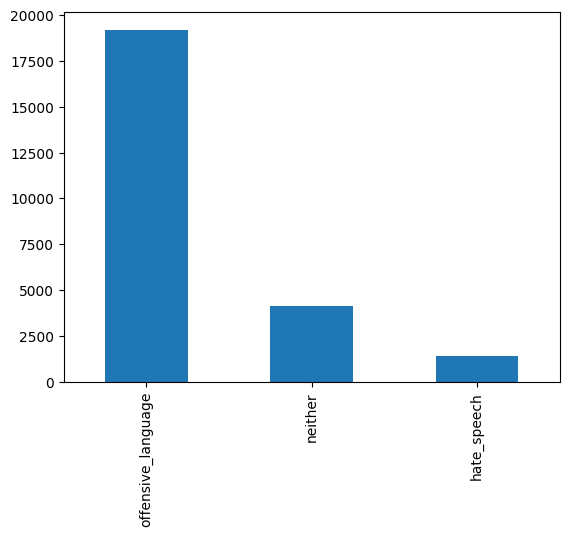

In [35]:
#plot distribution of label classes
twitter_df1['label'].value_counts().plot(kind='bar')
plt.show()

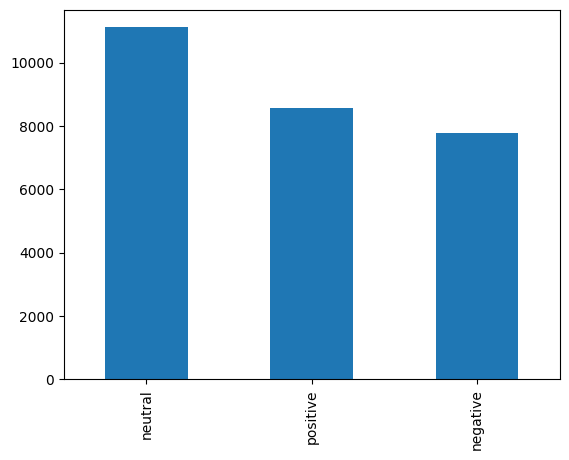

In [36]:
twitter_df2['label'].value_counts().plot(kind='bar')
plt.show()

In [37]:
#select non-offensive tweets by selecting only positive and neutral labels and shuffle
non_offensive_df = twitter_df2[(twitter_df2.label=='neutral')|(twitter_df2.label=='positive')].sample(frac=1).reset_index(drop=True)

non_offensive_df.head()

,tweet,label,tweet_clean
0,Hoping,positive,hoping
1,Mexican! That`s what I`m craving,neutral,mexican craving
2,Liked,positive,liked
3,hm... Both of us I guess...,neutral,hm u guess
4,out enjoying the weather be,positive,enjoying weather


In [38]:
non_offensive_df.shape

(19700, 3)

In [39]:
#concat tweet_df1 with non_offensive_df to balance labels
twitter_df = pd.concat([twitter_df1, non_offensive_df[:16457]], ignore_index=True, sort=False)
twitter_df.head()

,tweet,label,tweet_clean
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,woman complain cleaning house amp man always ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,boy dat cold tyga dwn bad cuffin dat hoe place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,dawg ever fuck bitch sta cry confused shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,shit hear might true might faker bitch told ya


In [40]:
#rename labels accordingly
twitter_df.label=twitter_df.label.replace({'positive': 'not_offensive', 'neutral': 'not_offensive','offensive_language':'offensive','hate_speech':'not_offensive','neither':'not_offensive'})

In [41]:
twitter_df.label.unique()

array(['not_offensive', 'offensive'], dtype=object)

In [42]:
twitter_df.shape

(41240, 3)

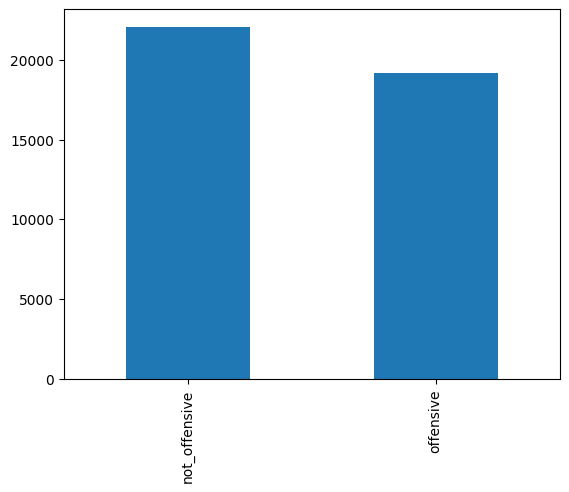

In [43]:
#plot distribution of label classes
twitter_df['label'].value_counts().plot(kind='bar')
plt.show()

In [44]:
#word cloud
twitter_mask = np.array(Image.open('twitter_mask3.jpg')) #fetch image for word cloud

#initialize word cloud object
wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)

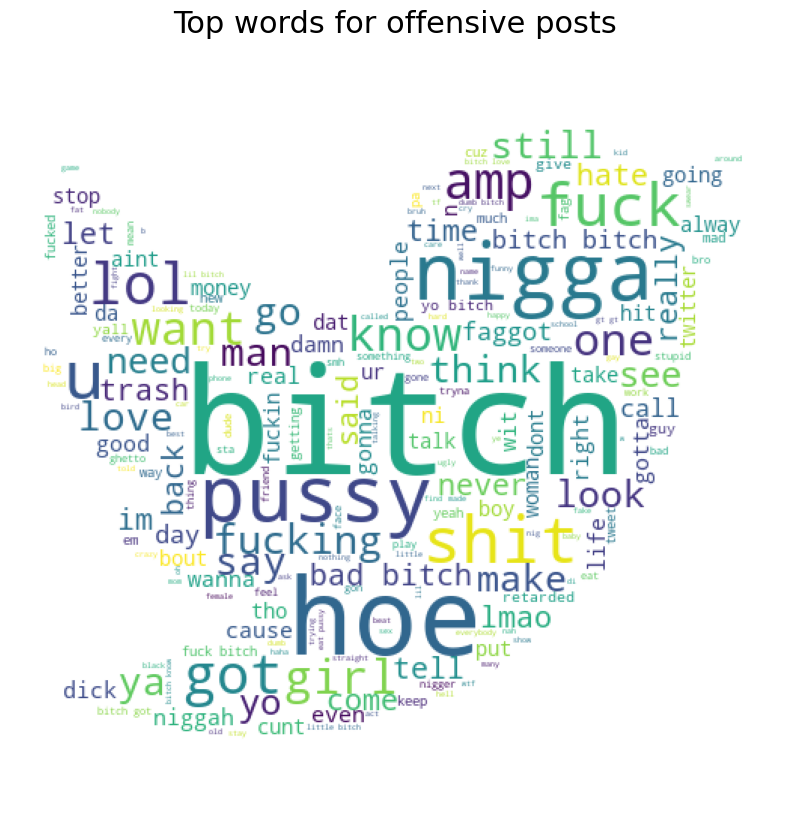

In [45]:
#visualize top words for offensive posts
wc.generate(' '.join(text for text in twitter_df.loc[twitter_df['label'] == 'offensive', 'tweet_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for offensive posts', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

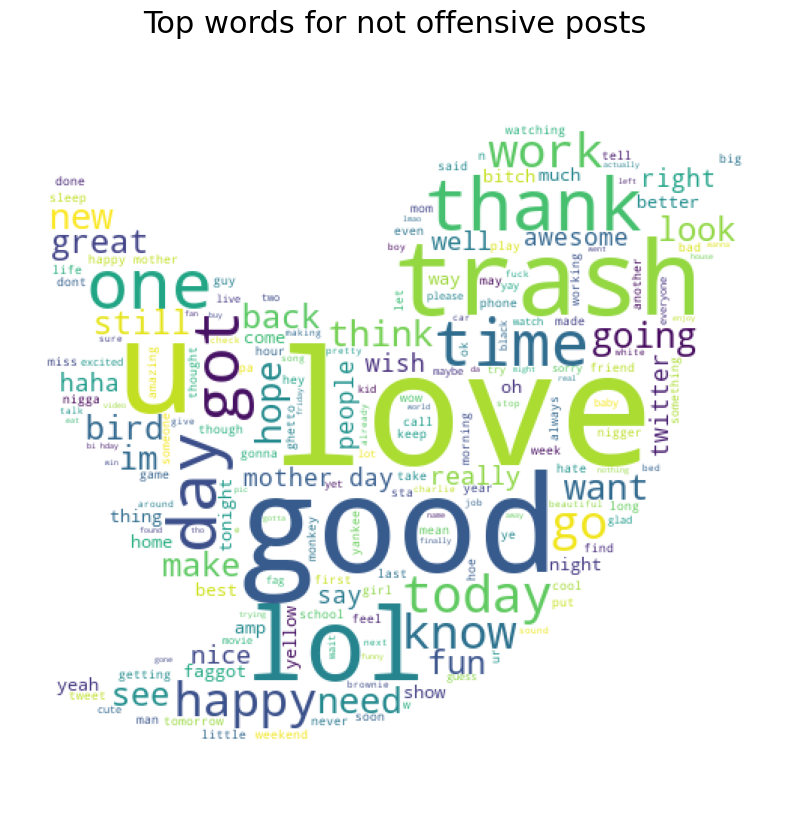

In [46]:
#visualize top words for not offensive posts
wc.generate(' '.join(text for text in twitter_df.loc[twitter_df['label'] != 'offensive', 'tweet_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for not offensive posts', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [47]:
#label encode tweet labels into numerical values
le=LabelEncoder()
twitter_df.label=le.fit_transform(twitter_df.label)
twitter_df

,tweet,label,tweet_clean
0,!!! RT @mayasolovely: As a woman you shouldn't...,0,woman complain cleaning house amp man always ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,boy dat cold tyga dwn bad cuffin dat hoe place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1,dawg ever fuck bitch sta cry confused shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1,look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,shit hear might true might faker bitch told ya
...,...,...,...
41235,morning romina.,0,morning romina
41236,. hopefull,0,hopefull
41237,plz dont fall in love with tokyo and never com...,0,plz dont fall love tokyo never come home
41238,hope you al have a lovely,0,hope al lovely


In [48]:
#label classes
le.classes_

array(['not_offensive', 'offensive'], dtype=object)

---

# Word Embeddings

In [37]:
#word tokenization: split tweets into smaller units (words)
word_tokens = [word_tokenize(row) for row in twitter_df['tweet_clean']]
word_tokens[:3]

[['woman',
  'complain',
  'cleaning',
  'house',
  'amp',
  'man',
  'always',
  'take',
  'trash'],
 ['boy', 'dat', 'cold', 'tyga', 'dwn', 'bad', 'cuffin', 'dat', 'hoe', 'place'],
 ['dawg', 'ever', 'fuck', 'bitch', 'sta', 'cry', 'confused', 'shit']]

## word2vec Technique

In [50]:
# define word2vec parameters
size = 200 #number of dimensions of the embeddings and the default is 100. default is 100
window = 3 #maximum distance between a target word and words around the target word. default is 5
min_count = 1 #minimum count of words to consider when training the model. default is 1
workers = 3 #number of partitions during training. default workers is 3
sg = 1 #training algorithm, either CBOW(0) or skip gram(1). default is 1

In [39]:
start_time = time.time()
# Train the Word2Vec Model on corpus
w2v_model = Word2Vec(word_tokens,
                     min_count = min_count,
                     vector_size = size,
                     workers = workers,
                     window = window,
                     sg = sg)
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model)

Time taken to train word2vec model: 5.389126539230347


In [59]:
# Load the model from the model file
w2v_model = Word2Vec.load(word2vec_model)

In [60]:
# Unique ID of the word
print("Index of the word 'woman':")
print(w2v_model.wv.key_to_index["woman"])

Index of the word 'woman':
136


In [61]:
#get the embedding of word: woman
w2v_model.wv.get_vector('woman')

array([ 4.48938739e-03, -4.77519090e-04,  5.70597798e-02,  1.15911543e-01,
        1.10719748e-01, -2.24848911e-02,  2.20454797e-01,  4.11608130e-01,
       -1.68142915e-01, -2.54971515e-02, -4.88019772e-02, -2.11968437e-01,
       -1.47253841e-01,  6.02327250e-02, -1.77515507e-01, -2.37894177e-01,
        1.22384593e-01,  2.61568516e-01, -4.14931439e-02, -4.16818291e-01,
        1.87571764e-01, -1.97590038e-01, -6.01503290e-02,  1.07675605e-01,
       -9.76011434e-05, -8.68060291e-02,  3.70194577e-02, -2.54229248e-01,
       -1.99866086e-01,  1.13502473e-01, -4.98653913e-04,  1.43923685e-01,
        2.40661040e-01, -6.34382591e-02, -3.81530076e-02,  6.92266077e-02,
        7.14607611e-02, -1.26544282e-01,  1.30052064e-02, -4.04881835e-01,
       -2.09634230e-01, -1.74417257e-01, -3.90927233e-02, -1.28610000e-01,
        3.40557009e-01, -2.95091197e-02, -1.30066887e-01, -1.12456247e-01,
        6.81550130e-02,  1.31960079e-01, -7.22347423e-02,  1.24572965e-04,
       -5.03030643e-02, -

In [62]:
#sample similar words: bitch
w2v_model.wv.similar_by_word("bitch")

[('hoe', 0.923511266708374),
 ('faggot', 0.8789234161376953),
 ('niggah', 0.876677930355072),
 ('nigga', 0.8755916953086853),
 ('ni', 0.8616114258766174),
 ('em', 0.8506597876548767),
 ('fuckin', 0.8384952545166016),
 ('aint', 0.8377202749252319),
 ('fuck', 0.8371670246124268),
 ('money', 0.8351484537124634)]

In [63]:
#sample similar words: happy
w2v_model.wv.similar_by_word("love")

[('called', 0.9557722210884094),
 ('though', 0.9540454149246216),
 ('pretty', 0.9533188939094543),
 ('thanks', 0.9518303871154785),
 ('send', 0.9506840705871582),
 ('made', 0.95051109790802),
 ('mine', 0.9502843618392944),
 ('lmao', 0.9502164721488953),
 ('funny', 0.9501606225967407),
 ('female', 0.950066864490509)]

In [64]:
# Total number of the words 
print(len(w2v_model.wv.key_to_index))

22616


In [65]:
# Print the size of the word2vec vector for one word
print("Length of the vector generated for a word")
print(len(w2v_model.wv['bitch']))

Length of the vector generated for a word
200


In [66]:
# total numberof extracted words.
vocab=w2v_model.wv.key_to_index
print("The total number of words are : ",len(vocab))

The total number of words are :  22616


In [67]:
# print(vocab)
vocab=list(vocab.keys())
vocab[:12]

['bitch',
 'hoe',
 'like',
 'pussy',
 'get',
 'got',
 'nigga',
 'u',
 'a',
 'lol',
 'love',
 'good']

In [68]:
word_vec_dict={}
for word in vocab:
    word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

The no of key-value pairs :  22616


In [69]:
word_vec_dict['bitch']

array([-1.16194382e-01,  5.99229485e-02,  2.80608326e-01,  1.43541649e-01,
       -2.37300158e-01, -3.32219340e-02,  1.28093228e-01,  4.15950388e-01,
       -2.23381981e-01, -1.26373110e-04,  5.35844415e-02, -3.00545841e-01,
       -8.96299109e-02,  2.25287825e-02, -7.33522475e-02, -1.51445970e-01,
        8.42035711e-02,  2.06078663e-01, -4.64896530e-01, -5.43484032e-01,
        1.13473028e-01, -1.22115433e-01, -4.18771710e-03,  5.77506907e-02,
        2.30637565e-02, -9.18613672e-02,  1.76284105e-01,  6.23705052e-03,
       -4.49103594e-01, -1.45787001e-01, -1.60310015e-01,  1.07418023e-01,
        2.40840942e-01, -1.14119127e-01,  4.56371391e-03, -2.46310934e-01,
        3.31463873e-01, -3.85419875e-01,  1.56869031e-02, -1.76782832e-01,
       -3.08765441e-01,  3.22088934e-02, -2.69021720e-01, -1.98035061e-01,
        3.37497085e-01, -1.46897435e-01, -6.02755696e-03, -6.25636950e-02,
        1.19116548e-02,  5.18690825e-01, -1.96022287e-01,  1.40644521e-01,
       -2.27756754e-01, -

In [70]:
# Create an embedding_matrix with shape (vocab_size, embedding_dim)
size = 200
embedding_matrix_w2v = np.zeros((len(vocab), size))

# Fill in the embedding_matrix with the corresponding embeddings
for i, word in enumerate(vocab):
    if word in word_vec_dict:
        embedding_matrix_w2v[i] = word_vec_dict[word]
    else:
        # If the word is not in the word2vec vocab dictionary, use a random initialization
        embedding_matrix_w2v[i] = np.random.rand(size)

In [71]:
embedding_matrix_w2v

array([[-1.16194382e-01,  5.99229485e-02,  2.80608326e-01, ...,
        -3.16251487e-01, -3.97933900e-01, -9.63727459e-02],
       [-6.07194416e-02, -2.31660008e-02,  2.44216248e-01, ...,
        -2.79662222e-01, -2.65811145e-01, -8.90319869e-02],
       [ 4.32329588e-02,  9.33075789e-03, -3.22466157e-02, ...,
        -2.09470540e-01,  7.07589462e-02,  4.22837585e-02],
       ...,
       [ 1.41487075e-02, -6.30517025e-03,  1.44939567e-03, ...,
        -2.14528330e-02, -1.04759214e-02,  3.44132306e-03],
       [ 9.87983122e-03, -1.05140321e-02,  4.63970099e-03, ...,
        -2.10487247e-02, -6.36781985e-03,  1.86440989e-03],
       [ 1.01772891e-02, -1.46238657e-04,  3.03659774e-03, ...,
        -1.04146181e-02, -3.21604288e-03,  6.59540249e-03]])

In [72]:
embedding_matrix_w2v.shape

(22616, 200)

In [73]:
# Convert the text data into numerical sequences using Word2Vec where values are the keys to the word2vec dictionary
num_sequences_w2v = [] 

for row in twitter_df['tweet_clean']:
    num_sequence = []
    for word in row.split():
        if word in w2v_model.wv.key_to_index.keys():
            num_sequence.append(w2v_model.wv.key_to_index[word])
    num_sequences_w2v.append(num_sequence)

In [74]:
num_sequences_w2v[0]

[136, 1215, 1081, 204, 21, 38, 88, 63, 18]

In [75]:
len(num_sequences_w2v)

41240

In [76]:
max_sequence_length = max(len(sequence) for sequence in num_sequences_w2v)  # max lenght of a tweet/text
max_sequence_length

28

In [77]:
# now padding to have a maximum length of 28
pad_tweets_w2v= pad_sequences(num_sequences_w2v, maxlen=max_sequence_length, padding='post')
pad_tweets_w2v.shape   # note that we had 41240 tweets and we have padded each review to have  a lenght of 28 words.

(41240, 28)

In [78]:
len(pad_tweets_w2v[0])

28

In [79]:
pad_tweets_w2v[0]

array([ 136, 1215, 1081,  204,   21,   38,   88,   63,   18,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

# Word Embeddings (GloVe)

In [70]:
#load pretrained model
glove_model = api.load("glove-twitter-100")

In [76]:
#save model
glove_model.save('glove-twitter-100.model')

In [36]:
#load model
glove_model = KeyedVectors.load('glove-twitter-100.model')

In [37]:
# Unique ID of the word
print("Index of the word 'woman':")
print(glove_model.key_to_index["woman"])

Index of the word 'woman':
1240


In [38]:
#get the embedding of word: love
glove_model['woman']

array([ 0.35761  , -0.55737  , -0.29762  ,  0.56073  , -0.3983   ,
       -0.21551  ,  0.59801  ,  0.13016  ,  0.60363  , -0.4305   ,
       -0.3259   ,  0.096317 , -4.1119   , -0.27945  ,  0.21279  ,
        0.28401  ,  0.26991  , -0.65553  ,  0.48464  ,  0.18451  ,
        1.0443   , -0.069635 , -0.098869 , -0.016446 , -0.25633  ,
        0.55831  , -0.50894  , -0.16896  , -0.6802   ,  0.49299  ,
        0.83425  , -0.4249   , -0.16513  ,  0.66931  ,  0.38609  ,
        0.47012  , -0.026249 ,  0.19812  , -0.3473   ,  0.034589 ,
       -0.25654  ,  0.26041  ,  0.45436  ,  0.061987 ,  0.79604  ,
        0.3097   ,  0.61956  ,  0.50329  , -0.12585  , -0.0071808,
       -0.83839  ,  0.29762  , -0.35479  , -0.50594  , -0.16857  ,
        0.062532 , -0.31103  ,  0.086456 , -0.66457  ,  0.80991  ,
        0.037768 ,  0.70021  ,  0.26671  , -0.33556  ,  0.3361   ,
        0.16335  ,  0.048709 , -0.16753  ,  0.32006  ,  0.2376   ,
       -0.01335  , -0.73784  ,  0.33628  , -0.70988  ,  0.3347

In [39]:
#sample similar words: woman
glove_model.most_similar('woman')

[('women', 0.8050916194915771),
 ('girl', 0.7974741458892822),
 ('wife', 0.7853384017944336),
 ('mother', 0.7815033793449402),
 ('person', 0.7773492932319641),
 ('female', 0.7678147554397583),
 ('guy', 0.7642642259597778),
 ('she', 0.7594019174575806),
 ('daughter', 0.740329921245575),
 ('child', 0.736954927444458)]

In [40]:
# total numberof extracted words.
vocab_glove=glove_model.key_to_index
print("The total number of words are : ",len(vocab_glove))

The total number of words are :  1193514


In [41]:
glove_dict={}
for word in vocab_glove:
    glove_dict[word]=glove_model.get_vector(word)
print("The no of key-value pairs : ",len(glove_dict)) # should come equal to vocab size

The no of key-value pairs :  1193514


In [42]:
# Create an embedding_matrix with shape (vocab_size, embedding_dim)
embedding_dim = 100
embedding_matrix_glove = np.zeros((len(vocab_glove), embedding_dim))

# Fill in the embedding_matrix with the corresponding embeddings
for i, word in enumerate(vocab_glove):
    if word in glove_dict:
        embedding_matrix_glove[i] = glove_dict[word]
    else:
        # If the word is not in the GloVe vocab dictionary, use a random initialization
        embedding_matrix_glove[i] = np.random.rand(embedding_dim)

In [43]:
embedding_matrix_glove

array([[ 0.63006002,  0.65177   ,  0.25545001, ...,  0.55096   ,
         0.64705998, -0.60930002],
       [ 0.18205   , -0.048483  ,  0.23965999, ..., -0.33579999,
         0.18884   , -0.40786001],
       [ 1.06739998,  0.45716   ,  0.51463002, ...,  0.13974001,
         0.76486999, -0.17314   ],
       ...,
       [ 0.28891999,  0.25407001,  0.11113   , ..., -0.61580002,
         0.046846  , -0.086387  ],
       [-0.38313001,  0.064609  ,  0.27384001, ..., -0.16395999,
        -0.26971   , -0.69941002],
       [-0.028777  , -0.72606999, -0.82770002, ..., -0.69694   ,
        -0.76516998, -1.09010005]])

In [44]:
embedding_matrix_glove.shape

(1193514, 100)

In [45]:
# Convert the text data into numerical sequences using GloVe where values are the keys to the GloVe dictionary
num_sequences_glove = [] 

for row in twitter_df['tweet_clean']:
    num_sequence = []
    for word in row.split():
        if word in glove_model:
            num_sequence.append(glove_model.key_to_index[word])
    num_sequences_glove.append(num_sequence)

In [46]:
num_sequences_glove[0]

[1240, 5032, 5639, 543, 12800, 246, 245, 284, 6740]

In [47]:
len(num_sequences_glove)

41240

In [50]:
max_sequence_length=max(len(sequence) for sequence in num_sequences_glove)

In [51]:
# now padding to have a maximum length of 28
pad_tweets_glove= pad_sequences(num_sequences_glove, maxlen=max_sequence_length, padding='post')
pad_tweets_glove.shape   # note that we had 41240 tweets and we have padded each review to have  a lenght of 28 words.

(41240, 28)

In [52]:
pad_tweets_glove[0]

array([ 1240,  5032,  5639,   543, 12800,   246,   245,   284,  6740,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

---

# Model Building

In [53]:
# prepare train and val sets first
y=tf.keras.utils.to_categorical(twitter_df['label'])  # one hot target as required by neural network.
y

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [80]:
#split w2v embedded data into train and test dataset
x_train1,x_test1,y_train1,y_test1=train_test_split(pad_tweets_w2v,y,test_size=0.20,random_state=42)

In [81]:
#split glove embedded data into train and test dataset
x_train2,x_test2,y_train2,y_test2=train_test_split(pad_tweets_glove,y,test_size=0.20,random_state=42)

In [98]:
# Define the hyperparameters
vocab_size_w2v = len(w2v_model.wv.key_to_index) # total no of words w2v
vocab_size_glove = len(glove_model.key_to_index) # total no of words glove
embed_dim_w2v=w2v_model.vector_size # embedding dimension as choosen in word2vec constructor
embed_dim_glove=glove_model.vector_size # embedding dimension as choosen in word2vec constructor
lstm_units=128
hidden_units = 64
dropout=0.2
num_classes = 2
learning_rate = 0.001
batch_size = 64
epochs = 20
steps_per_epoch=100

In [83]:
print(f'vocab size w2v:{vocab_size_w2v}')
print(f'vocab size glove:{vocab_size_glove}')
print(f'embed dim w2v:{embed_dim_w2v}')
print(f'embed dim glove:{embed_dim_glove}')
print(f'max sequence length:{max_sequence_length}')

vocab size w2v:22616
vocab size glove:1193514
embed dim w2v:200
embed dim glove:100
max sequence length:28


In [134]:
#Call back setup
mc = ModelCheckpoint(filepath='./base_model.h5',
                     monitor='val_loss',
                     verbose=1,
                     save_best_only=True)

es = EarlyStopping(monitor='val_loss',
                   min_delta=0.0001,
                   patience=3,
                   verbose=1)
cb = [mc,es]

## word2vec + LSTM

In [116]:
# define the model architecture :LSTM
lstm1 = Sequential()
lstm1.add(Embedding(input_dim=vocab_size_w2v, output_dim=embed_dim_w2v, weights=[embedding_matrix_w2v], input_length=max_sequence_length, trainable=False))
lstm1.add(LSTM(units=128, return_sequences=True, dropout=dropout, recurrent_dropout=dropout))
lstm1.add(LSTM(units=256, dropout=dropout, recurrent_dropout=dropout))
lstm1.add(Dense(units=512, activation='relu'))
lstm1.add(Dropout(dropout))
lstm1.add(Dense(units=num_classes, activation='softmax'))

lstm1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
lstm1.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 28, 200)           4523200   
                                                                 
 lstm_4 (LSTM)               (None, 28, 128)           168448    
                                                                 
 lstm_5 (LSTM)               (None, 256)               394240    
                                                                 
 dense_25 (Dense)            (None, 512)               131584    
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 5,218,498
Trainable params: 695,298
Non

In [117]:
# fitting the model.
lstm_hist1=lstm1.fit(x_train1,y_train1,epochs=epochs,steps_per_epoch=steps_per_epoch,batch_size=batch_size,callbacks=cb,validation_data=(x_test1,y_test1))

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5286
Epoch 1: val_loss improved from inf to 0.66814, saving model to .\base_model.h5
100/100 [==============================] - 83s 755ms/step - loss: 0.6910 - accuracy: 0.5286 - val_loss: 0.6681 - val_accuracy: 0.6254
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.5742 - accuracy: 0.7045
Epoch 2: val_loss improved from 0.66814 to 0.49481, saving model to .\base_model.h5
100/100 [==============================] - 98s 985ms/step - loss: 0.5742 - accuracy: 0.7045 - val_loss: 0.4948 - val_accuracy: 0.7836
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.4752 - accuracy: 0.7870
Epoch 3: val_loss improved from 0.49481 to 0.41052, saving model to .\base_model.h5
100/100 [==============================] - 112s 1s/step - loss: 0.4752 - accuracy: 0.7870 - val_loss: 0.4105 - val_accuracy: 0.8274
Epoch 4/20
100/100 [==============================] - ETA: 0s - 

In [ ]:
os.rename('base_model.h5','lstm1.h5')

## GloVe + LSTM

In [121]:
# Define the model architecture
lstm2 = Sequential()
lstm2.add(Embedding(input_dim=vocab_size_glove, output_dim=embed_dim_glove, weights=[embedding_matrix_glove], input_length=max_sequence_length, trainable=False))
lstm2.add(LSTM(units=128, return_sequences=True, dropout=dropout, recurrent_dropout=dropout))
lstm2.add(LSTM(units=256, dropout=dropout, recurrent_dropout=dropout))
lstm2.add(Dense(units=512, activation='relu'))
lstm2.add(Dropout(dropout))
lstm2.add(Dense(units=num_classes, activation='softmax'))

lstm2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
lstm2.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 28, 100)           119351400 
                                                                 
 lstm_8 (LSTM)               (None, 28, 128)           117248    
                                                                 
 lstm_9 (LSTM)               (None, 256)               394240    
                                                                 
 dense_29 (Dense)            (None, 512)               131584    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 119,995,498
Trainable params: 644,098
N

In [122]:
# fitting the model.
lstm_hist2=lstm2.fit(x_train2,y_train2,epochs=epochs,steps_per_epoch=steps_per_epoch,batch_size=batch_size,callbacks=cb,validation_data=(x_test2,y_test2))

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.3829 - accuracy: 0.8145
Epoch 1: val_loss improved from 0.31536 to 0.26446, saving model to .\base_model.h5
100/100 [==============================] - 152s 1s/step - loss: 0.3829 - accuracy: 0.8145 - val_loss: 0.2645 - val_accuracy: 0.9113
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.9167
Epoch 2: val_loss improved from 0.26446 to 0.20141, saving model to .\base_model.h5
100/100 [==============================] - 114s 1s/step - loss: 0.2287 - accuracy: 0.9167 - val_loss: 0.2014 - val_accuracy: 0.9286
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9264
Epoch 3: val_loss improved from 0.20141 to 0.18355, saving model to .\base_model.h5
100/100 [==============================] - 110s 1s/step - loss: 0.2075 - accuracy: 0.9264 - val_loss: 0.1835 - val_accuracy: 0.9325
Epoch 4/20
100/100 [==============================] - ETA: 0s - 

In [123]:
os.rename('base_model.h5','lstm2.h5')

## Word2Vec + GRU

In [131]:
# Define the model architecture
gru1 = Sequential()
gru1.add(Embedding(input_dim=vocab_size_glove, output_dim=embed_dim_glove, weights=[embedding_matrix_glove], input_length=max_sequence_length, trainable=False))
gru1.add(GRU(units=128, return_sequences=True, dropout=dropout, recurrent_dropout=dropout))
gru1.add(GRU(units=256, dropout=dropout, recurrent_dropout=dropout))
gru1.add(Dense(units=512, activation='relu'))
gru1.add(Dropout(dropout))
gru1.add(Dense(units=num_classes, activation='softmax'))

gru1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
gru1.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 28, 100)           119351400 
                                                                 
 gru_27 (GRU)                (None, 28, 128)           88320     
                                                                 
 gru_28 (GRU)                (None, 256)               296448    
                                                                 
 dense_35 (Dense)            (None, 512)               131584    
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_36 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 119,868,778
Trainable params: 517,378
N

In [132]:
# fitting the model
gru_hist1=gru1.fit(x_train1,y_train1,epochs=epochs,steps_per_epoch=steps_per_epoch,batch_size=batch_size,callbacks=cb,validation_data=(x_test1,y_test1))

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.6978 - accuracy: 0.5145
Epoch 1: val_loss improved from inf to 0.69071, saving model to .\base_model.h5
100/100 [==============================] - 117s 1s/step - loss: 0.6978 - accuracy: 0.5145 - val_loss: 0.6907 - val_accuracy: 0.5376
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.5202
Epoch 2: val_loss improved from 0.69071 to 0.68940, saving model to .\base_model.h5
100/100 [==============================] - 101s 1s/step - loss: 0.6940 - accuracy: 0.5202 - val_loss: 0.6894 - val_accuracy: 0.5700
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.6820 - accuracy: 0.5641
Epoch 3: val_loss improved from 0.68940 to 0.65923, saving model to .\base_model.h5
100/100 [==============================] - 99s 989ms/step - loss: 0.6820 - accuracy: 0.5641 - val_loss: 0.6592 - val_accuracy: 0.6306
Epoch 4/20
100/100 [==============================] - ETA: 0s - lo

In [133]:
os.rename('base_model.h5','gru1.h5')

## GloVe + GRU

In [135]:
# Define the model architecture
gru2 = Sequential()
gru2.add(Embedding(input_dim=vocab_size_glove, output_dim=embed_dim_glove, weights=[embedding_matrix_glove], input_length=max_sequence_length, trainable=False))
gru2.add(GRU(units=128, return_sequences=True, dropout=dropout, recurrent_dropout=dropout))
gru2.add(GRU(units=256, dropout=dropout, recurrent_dropout=dropout))
gru2.add(Dense(units=512, activation='relu'))
gru2.add(Dropout(dropout))
gru2.add(Dense(units=num_classes, activation='softmax'))

gru2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
gru2.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 28, 100)           119351400 
                                                                 
 gru_29 (GRU)                (None, 28, 128)           88320     
                                                                 
 gru_30 (GRU)                (None, 256)               296448    
                                                                 
 dense_37 (Dense)            (None, 512)               131584    
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                                 
 dense_38 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 119,868,778
Trainable params: 517,378
N

In [136]:
# fitting the model
gru_hist2=gru2.fit(x_train2,y_train2,epochs=epochs,steps_per_epoch=steps_per_epoch,batch_size=batch_size,callbacks=cb,validation_data=(x_test2,y_test2))

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.7012 - accuracy: 0.5061
Epoch 1: val_loss improved from inf to 0.68503, saving model to .\base_model.h5
100/100 [==============================] - 130s 1s/step - loss: 0.7012 - accuracy: 0.5061 - val_loss: 0.6850 - val_accuracy: 0.5375
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.3500 - accuracy: 0.8469
Epoch 2: val_loss improved from 0.68503 to 0.20528, saving model to .\base_model.h5
100/100 [==============================] - 119s 1s/step - loss: 0.3500 - accuracy: 0.8469 - val_loss: 0.2053 - val_accuracy: 0.9292
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.9258
Epoch 3: val_loss improved from 0.20528 to 0.17751, saving model to .\base_model.h5
100/100 [==============================] - 118s 1s/step - loss: 0.2056 - accuracy: 0.9258 - val_loss: 0.1775 - val_accuracy: 0.9366
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss

In [137]:
os.rename('base_model.h5','gru2.h5')

---

# Performance Evaluation

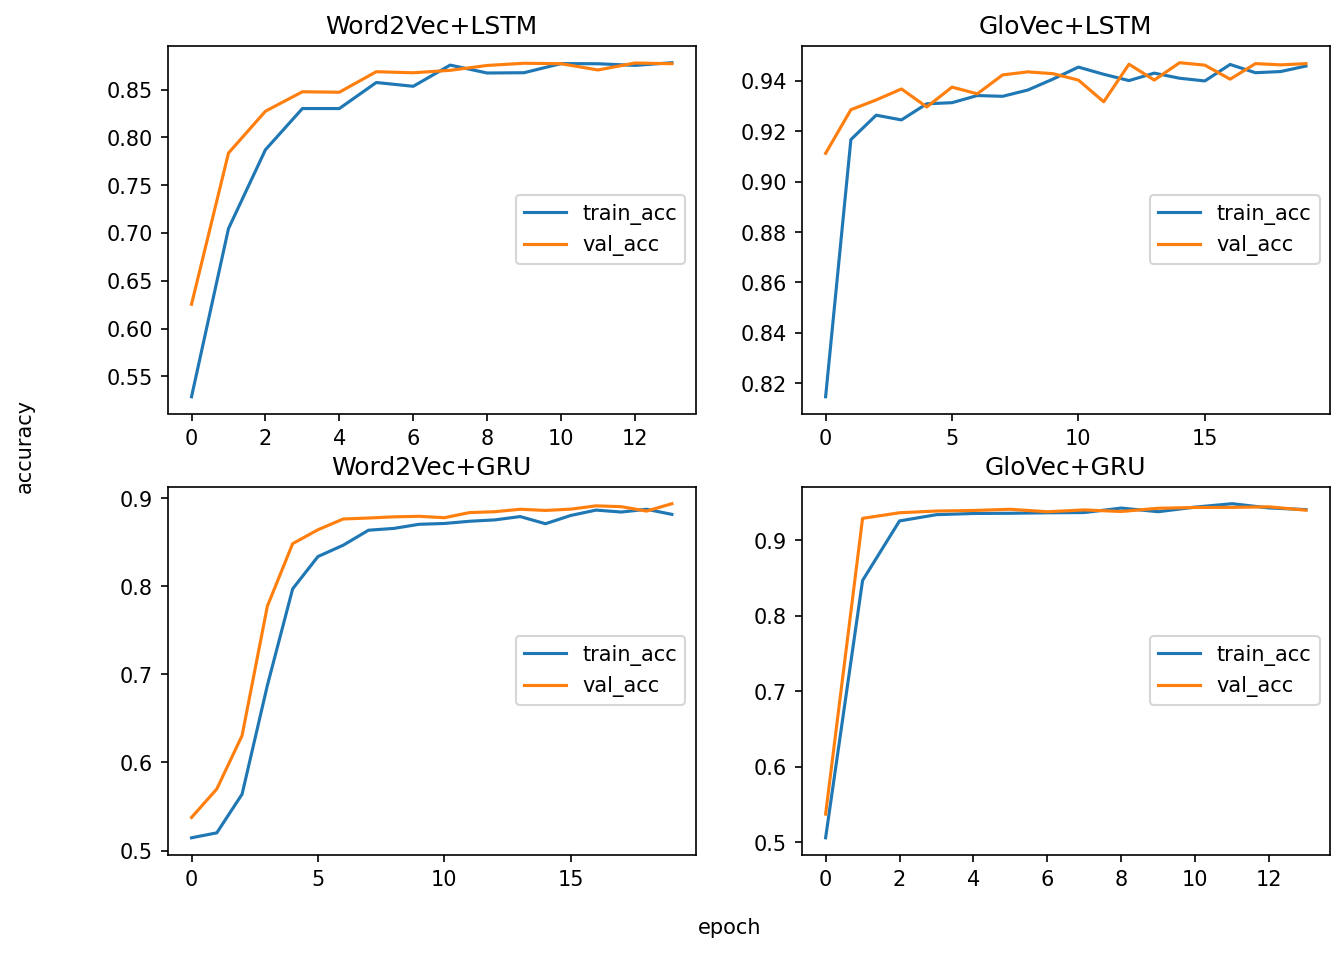

In [142]:
#plot train and validation accuracy across epochs
fig = plt.figure(dpi=150, figsize = (10,7))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(lstm_hist1.history['accuracy'], label='train_acc')
ax1.plot(lstm_hist1.history['val_accuracy'], label = 'val_acc')
ax1.legend(loc='center right')
ax2.plot(lstm_hist2.history['accuracy'], label='train_acc')
ax2.plot(lstm_hist2.history['val_accuracy'], label = 'val_acc')
ax2.legend(loc='center right')

ax3.plot(gru_hist1.history['accuracy'], label='train_acc')
ax3.plot(gru_hist1.history['val_accuracy'], label = 'val_acc')
ax3.legend(loc='center right')
ax4.plot(gru_hist2.history['accuracy'], label='train_acc')
ax4.plot(gru_hist2.history['val_accuracy'], label = 'val_acc')
ax4.legend(loc='center right')

fig.text(0.5, 0.04, 'epoch', ha='center', va='center')
fig.text(0.03, 0.5, 'accuracy', ha='center', va='center', rotation='vertical')

ax1.set_title('Word2Vec+LSTM')
ax2.set_title('GloVec+LSTM')
ax3.set_title('Word2Vec+GRU')
ax4.set_title('GloVec+GRU')
plt.show()

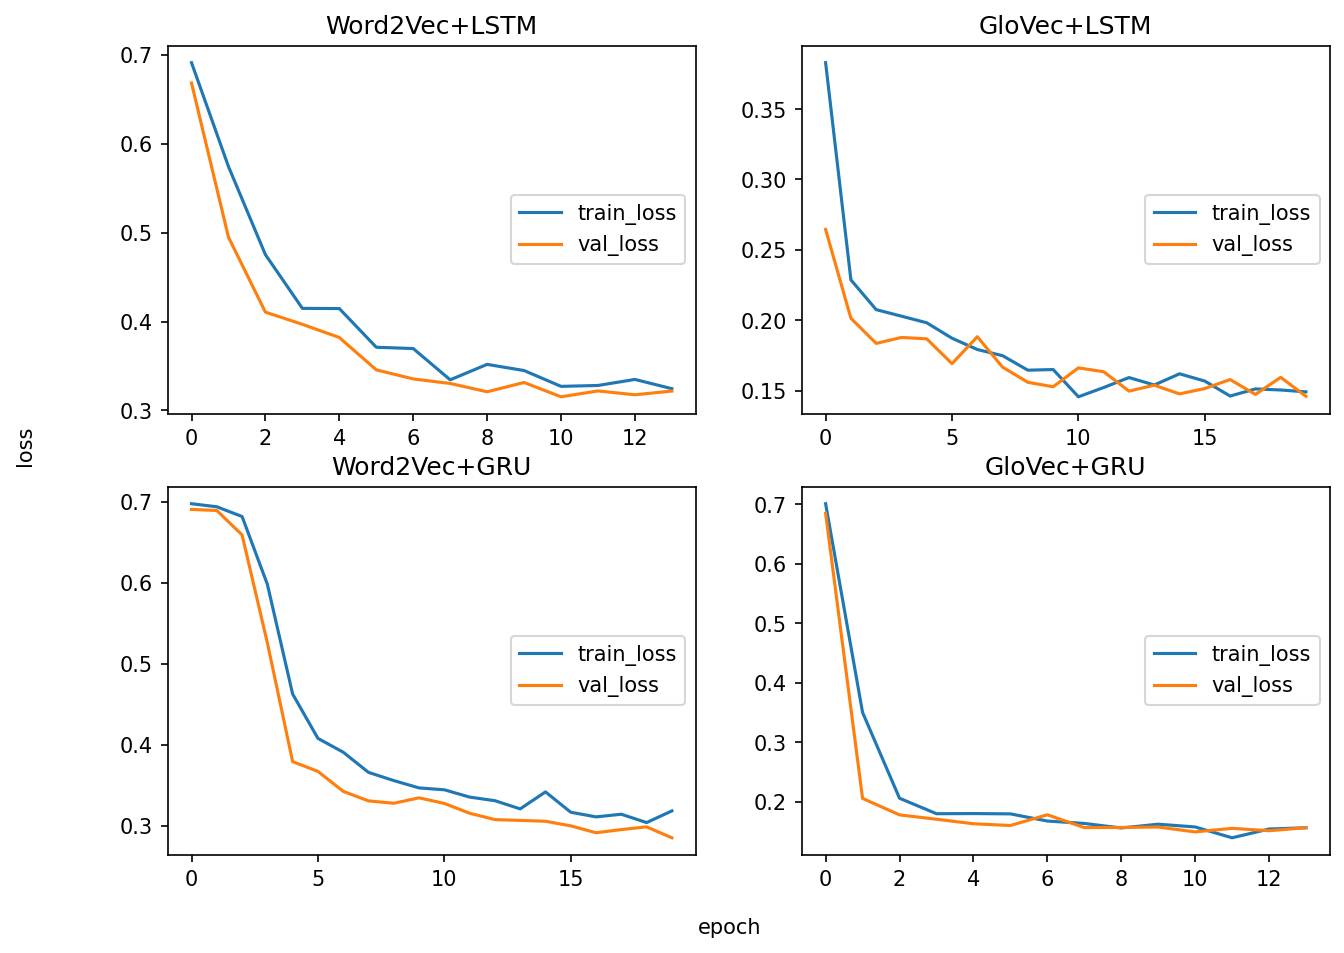

In [144]:
#plot train and validation loss across epochs
fig = plt.figure(dpi=150, figsize = (10,7))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(lstm_hist1.history['loss'], label='train_loss')
ax1.plot(lstm_hist1.history['val_loss'], label = 'val_loss')
ax1.legend(loc='center right')
ax2.plot(lstm_hist2.history['loss'], label='train_loss')
ax2.plot(lstm_hist2.history['val_loss'], label = 'val_loss')
ax2.legend(loc='center right')

ax3.plot(gru_hist1.history['loss'], label='train_loss')
ax3.plot(gru_hist1.history['val_loss'], label = 'val_loss')
ax3.legend(loc='center right')
ax4.plot(gru_hist2.history['loss'], label='train_loss')
ax4.plot(gru_hist2.history['val_loss'], label = 'val_loss')
ax4.legend(loc='center right')

fig.text(0.5, 0.04, 'epoch', ha='center', va='center')
fig.text(0.03, 0.5, 'loss', ha='center', va='center', rotation='vertical')

ax1.set_title('Word2Vec+LSTM')
ax2.set_title('GloVec+LSTM')
ax3.set_title('Word2Vec+GRU')
ax4.set_title('GloVec+GRU')
plt.show()

In [145]:
#confusion matrix plot function 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `noramlize=True`
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('confusion matrix, without Normalized')
    
    print(cm)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [146]:
labels = le.classes_
labels

array(['not_offensive', 'offensive'], dtype=object)

In [147]:
# model prediction: LSTM1
lstm1_pred = lstm1.predict(x=x_test1, verbose=0)
lstm1_pred

array([[0.89363605, 0.10636396],
       [0.948574  , 0.05142596],
       [0.54437274, 0.45562726],
       ...,
       [0.01670411, 0.98329586],
       [0.94455785, 0.05544211],
       [0.83787507, 0.16212493]], dtype=float32)

In [148]:
#get argmax of predictions
lstm1_pred = np.argmax(lstm1_pred, axis=1)
lstm1_pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [149]:
y_test_argmax =np.argmax(y_test1, axis=1)

In [150]:
#generate classification report
print(classification_report(y_true=y_test_argmax, y_pred=lstm1_pred, target_names=labels))

               precision    recall  f1-score   support

not_offensive       0.84      0.96      0.89      4434
    offensive       0.94      0.78      0.85      3814

     accuracy                           0.88      8248
    macro avg       0.89      0.87      0.87      8248
 weighted avg       0.89      0.88      0.88      8248



confusion matrix, without Normalized
[[4256  178]
 [ 836 2978]]


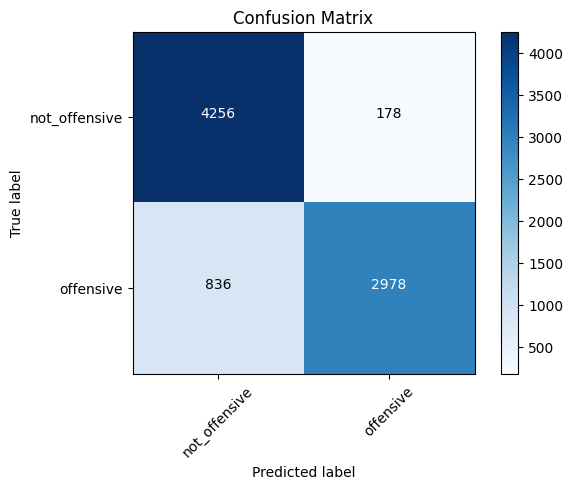

In [151]:
#confusion matrix
lstm1_cm =confusion_matrix(y_test_argmax, lstm1_pred)

#plot confusion matrix for custom model
plot_confusion_matrix(cm=lstm1_cm, classes=labels)

---

In [152]:
# model prediction: LSTM2
lstm2_pred = lstm2.predict(x=x_test2, verbose=0)
lstm2_pred

array([[9.9548596e-01, 4.5139818e-03],
       [9.9899858e-01, 1.0014677e-03],
       [4.2819670e-01, 5.7180333e-01],
       ...,
       [1.6325243e-02, 9.8367476e-01],
       [9.9925286e-01, 7.4715138e-04],
       [9.9893612e-01, 1.0639274e-03]], dtype=float32)

In [153]:
#get argmax of predictions
lstm2_pred = np.argmax(lstm2_pred, axis=1)
lstm2_pred

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [154]:
#generate classification report
print(classification_report(y_true=y_test_argmax, y_pred=lstm2_pred, target_names=labels))

               precision    recall  f1-score   support

not_offensive       0.97      0.93      0.95      4434
    offensive       0.92      0.97      0.94      3814

     accuracy                           0.95      8248
    macro avg       0.95      0.95      0.95      8248
 weighted avg       0.95      0.95      0.95      8248



confusion matrix, without Normalized
[[4126  308]
 [ 130 3684]]


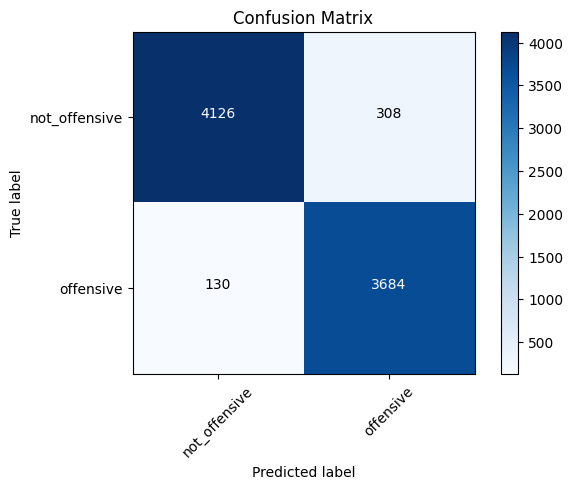

In [155]:
#confusion matrix
lstm2_cm =confusion_matrix(y_test_argmax, lstm2_pred)

#plot confusion matrix for custom model
plot_confusion_matrix(cm=lstm2_cm, classes=labels)

----

In [156]:
# model prediction: GRU1
gru1_pred = gru1.predict(x=x_test1, verbose=0)
gru1_pred

array([[0.8991335 , 0.10086654],
       [0.7527594 , 0.24724059],
       [0.10616023, 0.89383984],
       ...,
       [0.01099487, 0.98900515],
       [0.8867015 , 0.11329845],
       [0.8408414 , 0.15915856]], dtype=float32)

In [157]:
#get argmax of predictions
gru1_pred = np.argmax(gru1_pred, axis=1)
gru1_pred

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [158]:
#generate classification report
print(classification_report(y_true=y_test_argmax, y_pred=gru1_pred, target_names=labels))

               precision    recall  f1-score   support

not_offensive       0.86      0.95      0.91      4434
    offensive       0.94      0.82      0.88      3814

     accuracy                           0.89      8248
    macro avg       0.90      0.89      0.89      8248
 weighted avg       0.90      0.89      0.89      8248



confusion matrix, without Normalized
[[4231  203]
 [ 674 3140]]


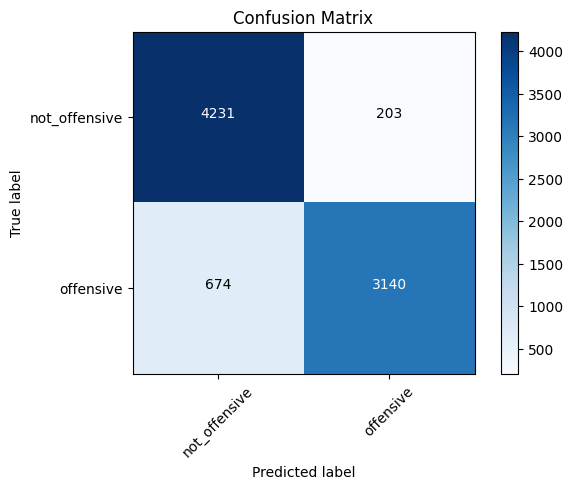

In [159]:
#confusion matrix
lstm2_cm =confusion_matrix(y_test_argmax, gru1_pred)

#plot confusion matrix for custom model
plot_confusion_matrix(cm=lstm2_cm, classes=labels)

---

In [160]:
# model prediction: GRU2
gru2_pred = gru2.predict(x=x_test2, verbose=0)
gru2_pred

array([[0.9816726 , 0.01832741],
       [0.9909348 , 0.00906514],
       [0.6713785 , 0.32862148],
       ...,
       [0.02374785, 0.9762522 ],
       [0.99541014, 0.0045898 ],
       [0.99199873, 0.00800128]], dtype=float32)

In [161]:
#get argmax of predictions
gru2_pred = np.argmax(gru2_pred, axis=1)
gru2_pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [162]:
#generate classification report
print(classification_report(y_true=y_test_argmax, y_pred=gru2_pred, target_names=labels))

               precision    recall  f1-score   support

not_offensive       0.92      0.97      0.95      4434
    offensive       0.96      0.91      0.93      3814

     accuracy                           0.94      8248
    macro avg       0.94      0.94      0.94      8248
 weighted avg       0.94      0.94      0.94      8248



confusion matrix, without Normalized
[[4287  147]
 [ 348 3466]]


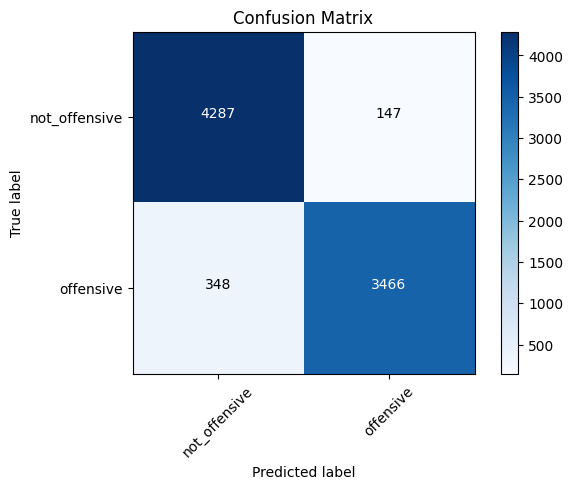

In [163]:
#confusion matrix
lstm2_cm =confusion_matrix(y_test_argmax, gru2_pred)

#plot confusion matrix for custom model
plot_confusion_matrix(cm=lstm2_cm, classes=labels)

---

# Testing

In [164]:
def predict_post(text):
    
    cleaned_text = clean_text(text) #remove punctuations
    cleaned_text = remove_stopwords(cleaned_text) #remove stop words
    cleaned_text = lemmatize_text(cleaned_text) #stem words in text
    
    # Convert the text data into numerical sequences using GloVec
    vec_sequences = []
    for word in cleaned_text.split():
        if word in glove_model:
            vec_sequences.append(glove_model.key_to_index[word])
    vec_sequences=[vec_sequences]
    
    padded_text= pad_sequences(vec_sequences, maxlen=max_sequence_length, padding='post') #pad text to fit neural network
    pred = lstm2.predict(padded_text, verbose=0) #run model to get prediction
    labels = le.classes_
    return labels[np.argmax(pred)]

In [165]:
text = 'happy'

In [166]:
predict_post(text)

'not_offensive'

In [167]:
text2 = 'That is good'

In [168]:
predict_post(text2)

'not_offensive'

In [169]:
text3 ='hoe'

In [170]:
predict_post(text3)

'offensive'

In [171]:
predict_post('stop acting like a fucking nigga')

'offensive'

In [172]:
predict_post('bitch')

'offensive'